In [1]:
import cv2
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

0.308

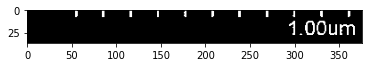

In [2]:
# Calculate the translation between scale bar & pixels
def dist_btw_scale_bar(lst, value):
    '''
    Args:
        lst: a row in the image that cuts thru the scale bar
        value: usually = 255 if white

    Returns:
        length of distance between scale bar in pixels
    '''
    # find first occurance of white scale bar
    j = lst.index(value)

    # find last occurance of white scale bar
    lst.reverse()
    i = lst.index(value)
    lst.reverse()

    return (len(lst) - i - 1) - j

def translate_pixel_to_nm(length_pixel, scale_bar_length):
    '''
    Args:
        length_pixel: from `dist_btw_scale_bar`, the number of pixels between scale bar
        scale_bar_length: actual scale bar length from SEM

    Returns:
        physical length of each pixel in nanometer  
    '''
    return length_pixel / scale_bar_length


img = cv2.imread('AAO_temp2.jpg', cv2.IMREAD_GRAYSCALE)
scale_bar = img[545:-1, 400:-1]
ret,thresh1 = cv2.threshold(scale_bar,80,255,cv2.THRESH_BINARY)
thresh_row = thresh1[1].tolist()
plt.imshow(thresh1,cmap="gray")


length_pixel = dist_btw_scale_bar(thresh_row,255)
pixel_to_nm = translate_pixel_to_nm(length_pixel, 1E3)
pixel_to_nm


0.19651556318222985

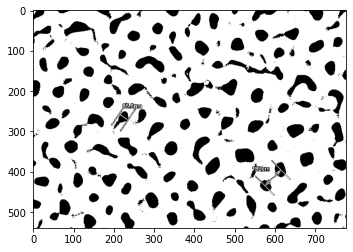

In [24]:
# load img and crop away scale bar
img = cv2.imread('AAO_temp2.jpg', cv2.IMREAD_GRAYSCALE)
cropped_image = img[0:540, :]

# binary thresholding, change threshold if needed
ret,thresh1 = cv2.threshold(cropped_image,80,255,cv2.THRESH_BINARY)

# blur = cv2.GaussianBlur(cropped_image,(5,5),0)
ret3,th3 = cv2.threshold(cropped_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(th3,cmap="gray")

plt.imshow(th3,cmap="gray")
plt.imshow(thresh1,cmap="gray")


sum_row = []
for row in thresh1:
    sum_row.append(sum(row))

# Total percentage area occupied by the holes 
1-sum(sum_row)/255/(540*777)


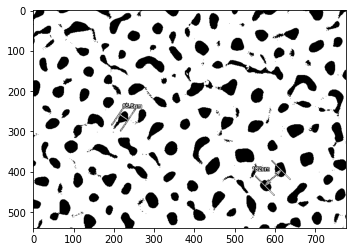

In [25]:
plt.imshow(th3,cmap="gray")

In [27]:
from sklearn.cluster import DBSCAN

def annotate_image_with_labels(img, eps=8, min_samples=30, threshold=50):
    '''
    Loads the image, find clusters with DBSCAN algorithm and annotate them on image

    Returns:
        centroid_x, centroid_y: two lists with x and y coordinates of the centroid for each hole
        num_holes: an int of total number of holes on image
        area: a list of ints representing total amount of pixels within each label
    '''

    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = img[0:540, :]
    original_img = cv2.imread(image_path)
    
    # Apply thresholding to create a binary image

    blur = cv2.GaussianBlur(cropped_image,(5,5),0)
    ret3,binary_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # _, binary_img = cv2.threshold(cropped_image, threshold, 255, cv2.THRESH_BINARY_INV)
    
    # Find coordinates of white pixels (dark spots)
    dark_spots_coords = np.column_stack(np.where(binary_img == 0))
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(dark_spots_coords)
    
    # Initialize dictionary to store cluster centroids
    cluster_centers = {}
    area = []
    
    # Iterate over labels and calculate centroids
    for label, coord in zip(dbscan.labels_, dark_spots_coords):
        
        if label != -1:  # Ignore noise points
            if label not in cluster_centers:
                cluster_centers[label] = [coord]
                area.append(0)
            else:
                cluster_centers[label].append(coord)
                area[-1] += 1

    
    centroids_x = []
    centroids_y = []
    # Annotate the original image with labels at cluster centroids
    for label, coords in cluster_centers.items():
        center = np.mean(coords, axis=0).astype(int)
        x, y = center[0], center[1]
        cv2.putText(original_img, str(label), (y, x), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        centroids_x.append(center[0])
        centroids_y.append(center[1])

    # Display the annotated image
    cv2.imshow('Annotated Image', original_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return centroids_x, centroids_y, max(dbscan.labels_), cluster_centers


image_path = 'AAO_temp2.jpg' 
cen_x,cen_y,num_holes,area_dots = annotate_image_with_labels(image_path)


QObject::moveToThread: Current thread (0x55d362775b10) is not the object's thread (0x55d36836e310).
Cannot move to target thread (0x55d362775b10)

QObject::moveToThread: Current thread (0x55d362775b10) is not the object's thread (0x55d36836e310).
Cannot move to target thread (0x55d362775b10)

QObject::moveToThread: Current thread (0x55d362775b10) is not the object's thread (0x55d36836e310).
Cannot move to target thread (0x55d362775b10)

QObject::moveToThread: Current thread (0x55d362775b10) is not the object's thread (0x55d36836e310).
Cannot move to target thread (0x55d362775b10)

QObject::moveToThread: Current thread (0x55d362775b10) is not the object's thread (0x55d36836e310).
Cannot move to target thread (0x55d362775b10)

QObject::moveToThread: Current thread (0x55d362775b10) is not the object's thread (0x55d36836e310).
Cannot move to target thread (0x55d362775b10)

QObject::moveToThread: Current thread (0x55d362775b10) is not the object's thread (0x55d36836e310).
Cannot move to tar

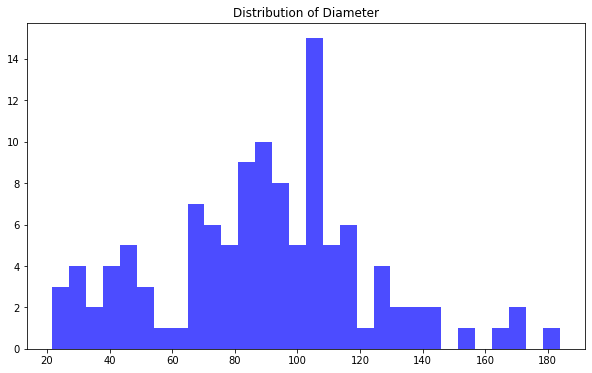

In [6]:
cluster_size = []
diameter = []
for i in range(len(area_dots)):
    cluster_size.append(len(area_dots[i])/pixel_to_nm**2)
    diameter.append(2*math.sqrt(len(area_dots[i])/pixel_to_nm**2/3.14))

plt.figure(figsize=(10, 6))
plt.hist(diameter, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Diameter')
plt.show()

number of holes in this area: 114


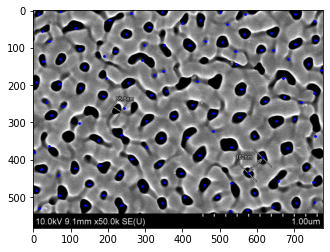

In [7]:
# Sanity check: make sure that the centroid is correctly located at the centre of each cluster
img = cv2.imread('AAO_temp2.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.scatter(cen_y,cen_x,s=3,c="b")
print("number of holes in this area: " + str(num_holes))

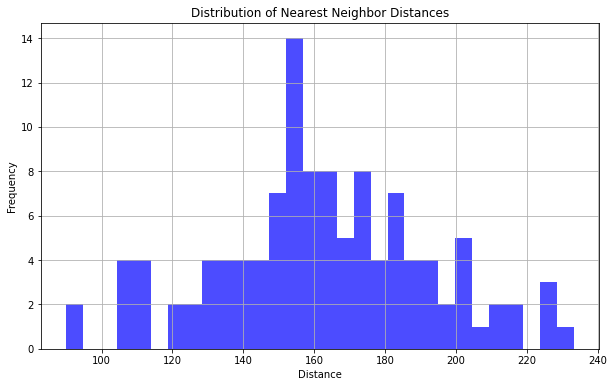

In [8]:
from scipy.spatial import KDTree

dots = np.column_stack((cen_x, cen_y))

# Use KDTree for efficient nearest neighbor search
tree = KDTree(dots)

# Find the nearest neighbor for each dot (excluding itself)
distances, _ = tree.query(dots, k=4)  # k=2 to get the first nearest neighbor, excluding the point itself

# distances[:,1] contains the distance to the nearest neighbor
nearest_neighbor_distances = distances[:, 1]/pixel_to_nm

# Plotting the distribution of nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.hist(nearest_neighbor_distances, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Nearest Neighbor Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

